In [18]:
from google.colab import files
uploaded = files.upload()

Saving Smartgrid.csv to Smartgrid.csv


Importing Libarires

In [1]:
import pandas as pd
import numpy as np
import random
import time
import multiprocessing
import matplotlib.pyplot as plt
import threading
import psutil

Monitoring (CPU)

In [2]:

cpu_usage_data = []
monitoring = False

In [3]:

def monitor_system_usage():
    global cpu_usage_data, monitoring
    cpu_usage_data = []
    while monitoring:
        cpu_usage_data.append(psutil.cpu_percent(interval=0.1))

In [4]:


def start_monitoring():
    global monitoring
    monitoring = True
    thread = threading.Thread(target=monitor_system_usage, daemon=True)
    thread.start()
    return thread

In [5]:

def stop_monitoring():
    global monitoring
    monitoring = False


Dataset Loader

In [6]:
def load_energy_data(file_path):
    df = pd.read_csv(file_path)
    districts = df['district'].unique()
    num_timeslots = df.groupby('district')['timestamp'].nunique().max()

    demand_matrix = []
    solar_matrix = []
    hydro_matrix = []
    price_matrix = []
    penalty_matrix = []
    loss_matrix = []
    peak_hours = []

    for d in districts:
        sub_df = df[df['district'] == d].reset_index(drop=True)
        # Pad or truncate the data for each district to match the maximum number of timeslots
        demand_matrix.append(np.pad(sub_df['demand_kw'].values, (0, num_timeslots - len(sub_df)), 'constant'))
        solar_matrix.append(np.pad(sub_df['solar_supply_kw'].values, (0, num_timeslots - len(sub_df)), 'constant'))
        hydro_matrix.append(np.pad(sub_df['hydro_supply_kw'].values, (0, num_timeslots - len(sub_df)), 'constant'))
        price_matrix.append(np.pad(sub_df['grid_price_per_kwh'].values, (0, num_timeslots - len(sub_df)), 'constant'))
        penalty_matrix.append(np.pad(sub_df['penalty_per_kw_unmet'].values, (0, num_timeslots - len(sub_df)), 'constant'))
        loss_matrix.append(np.pad(sub_df['line_loss_percent'].values / 100, (0, num_timeslots - len(sub_df)), 'constant'))
        if len(peak_hours) == 0: # Assuming peak_hours is the same for all districts
             peak_hours = sub_df['peak_hour'].values[:num_timeslots]


    return {
        'districts': districts,
        'num_nodes': len(districts),
        'num_sources': 2,
        'num_timeslots': num_timeslots,
        'demand_matrix': np.array(demand_matrix),
        'capacity_matrix': np.array([solar_matrix, hydro_matrix]),  # shape: (2, num_nodes, T)
        'price_matrix': np.array(price_matrix),
        'penalty_matrix': np.array(penalty_matrix),
        'loss_matrix': np.array(loss_matrix),
        'peak_hours': np.array(peak_hours)
    }

Cost Matrix and penalty weights

In [7]:
COST_WEIGHT = 1.0
CAPACITY_PENALTY_WEIGHT = 50
DEMAND_PENALTY_WEIGHT = 100
PEAK_PENALTY_WEIGHT = 50

def create_cost_matrix(data):
    """Dynamic cost matrix per source-node (avg)"""
    return np.array([
        [1.0]*data['num_nodes'],
        [1.8]*data['num_nodes']
    ])


Poulation Initiallization

In [8]:
def initialize_population(data, pop_size):
    pop = []
    for _ in range(pop_size):
        chromo = np.zeros((data['num_sources'], data['num_nodes'], data['num_timeslots']))
        for t in range(data['num_timeslots']):
            for n in range(data['num_nodes']):
                demand = data['demand_matrix'][n, t]
                solar_cap = data['capacity_matrix'][0][n, t]
                hydro_cap = data['capacity_matrix'][1][n, t]

                # Random proportion between 0.2 to 0.8
                prop = random.uniform(0.2, 0.8)
                solar_alloc = min(demand * prop, solar_cap)
                hydro_alloc = min(demand * (1 - prop), hydro_cap)

                chromo[0, n, t] = solar_alloc
                chromo[1, n, t] = hydro_alloc

        pop.append(chromo.flatten())
    return pop

Total Energy Cost Calculaton

In [9]:

def compute_total_cost(chromo, data, cost_matrix):
    chromo = chromo.reshape(data['num_sources'], data['num_nodes'], data['num_timeslots'])
    total_cost = 0
    for t in range(data['num_timeslots']):
        for s in range(data['num_sources']):
            for n in range(data['num_nodes']):
                energy = chromo[s, n, t]
                loss = data['loss_matrix'][n, t]
                total_cost += energy * cost_matrix[s, n] * (1 + loss)
    return total_cost * COST_WEIGHT


Pennalty Calculation

In [10]:

def compute_capacity_penalty(chromo, data):
    chromo = chromo.reshape(data['num_sources'], data['num_nodes'], data['num_timeslots'])
    penalty = 0
    for t in range(data['num_timeslots']):
        for s in range(data['num_sources']):
            for n in range(data['num_nodes']):
                if chromo[s, n, t] > data['capacity_matrix'][s][n, t]:
                    penalty += (chromo[s, n, t] - data['capacity_matrix'][s][n, t]) * CAPACITY_PENALTY_WEIGHT
    return penalty

In [11]:

def compute_demand_penalty(chromo, data):
    chromo = chromo.reshape(data['num_sources'], data['num_nodes'], data['num_timeslots'])
    penalty = 0
    for t in range(data['num_timeslots']):
        for n in range(data['num_nodes']):
            received = np.sum(chromo[:, n, t])
            demand = data['demand_matrix'][n, t]
            penalty += abs(received - demand) * DEMAND_PENALTY_WEIGHT
    return penalty

In [12]:
def compute_peak_penalty(chromo, data):
    chromo = chromo.reshape(data['num_sources'], data['num_nodes'], data['num_timeslots'])
    penalty = 0
    for t in range(data['num_timeslots']):
        if data['peak_hours'][t] == 1:
            total = np.sum(chromo[:, :, t])
            if total > 100:
                penalty += (total - 100) * PEAK_PENALTY_WEIGHT
    return penalty

Fitness Function

In [13]:


def fitness(chromo, data, cost_matrix):
    return (
        compute_total_cost(chromo, data, cost_matrix) +
        compute_capacity_penalty(chromo, data) +
        compute_demand_penalty(chromo, data) +
        compute_peak_penalty(chromo, data)
    )

Crossover and mutatation

In [14]:
def select_parents(pop, fits, k=3):
    return [min(random.sample(list(zip(fits, pop)), k), key=lambda x: x[0])[1] for _ in range(2)]

def crossover(p1, p2):
    a, b = sorted(random.sample(range(len(p1)), 2))
    c1 = np.concatenate([p1[:a], p2[a:b], p1[b:]])
    c2 = np.concatenate([p2[:a], p1[a:b], p2[b:]])
    return c1, c2

def mutate(chromo, rate=0.3, strength=0.5):
    for i in range(len(chromo)):
        if random.random() < rate:
            chromo[i] += chromo[i] * strength * (random.random() * 2 - 1)
            chromo[i] = max(chromo[i], 0)
    return chromo

Running Genetic Algorithm

In [15]:


def run_ga(data, pop_size=50, generations=60, parallel=False):
    cost_matrix = create_cost_matrix(data)
    pop = initialize_population(data, pop_size)

    best_fit = float('inf')
    best_sol = None
    history = []

    if parallel:
        pool = multiprocessing.Pool()

    for g in range(generations):
        if parallel:
            fits = pool.starmap(fitness, [(ind, data, cost_matrix) for ind in pop])
        else:
            fits = [fitness(ind, data, cost_matrix) for ind in pop]

        best_idx = np.argmin(fits)
        if fits[best_idx] < best_fit:
            best_fit = fits[best_idx]
            best_sol = pop[best_idx]

        history.append(best_fit)
        new_pop = [pop[best_idx]]

        while len(new_pop) < pop_size:
            p1, p2 = select_parents(pop, fits)
            c1, c2 = crossover(p1, p2)
            new_pop.append(mutate(c1))
            if len(new_pop) < pop_size:
                new_pop.append(mutate(c2))
        pop = new_pop

    if parallel:
        pool.close()
        pool.join()

    return best_sol, best_fit, history

Visuallization

In [16]:


def plot_results(baseline, serial, parallel, t_serial, t_parallel, h_serial, h_parallel):
    plt.figure(figsize=(10, 5))
    plt.plot(h_serial, label="Serial GA")
    plt.plot(h_parallel, label="Parallel GA")
    plt.axhline(baseline, linestyle='--', color='r', label="Greedy")
    plt.title("Fitness Convergence")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure()
    plt.bar(["Serial", "Parallel"], [t_serial, t_parallel])
    plt.title("Execution Time")
    plt.ylabel("Seconds")
    plt.grid(True)
    plt.show()

    plt.figure()
    bars = plt.bar(["Greedy", "Serial GA", "Parallel GA"], [baseline, serial, parallel], color=["red", "blue", "green"])
    plt.title("Final Fitness Comparison")
    plt.ylabel("Fitness (Lower is Better)")
    plt.grid(True, axis='y')

    if cpu_usage_data:
        plt.figure()
        plt.plot(cpu_usage_data)
        plt.title("CPU Usage (%)")
        plt.xlabel("Time")
        plt.ylabel("CPU %")
        plt.grid(True)
        plt.show()

Serial and Parallel Comparison

Running Greedy Baseline...
Greedy fitness: 700728.26

Running Serial GA...
Serial GA fitness: 657960.17 in 16.61s

Running Parallel GA...
Parallel GA fitness: 657815.86 in 8.02s


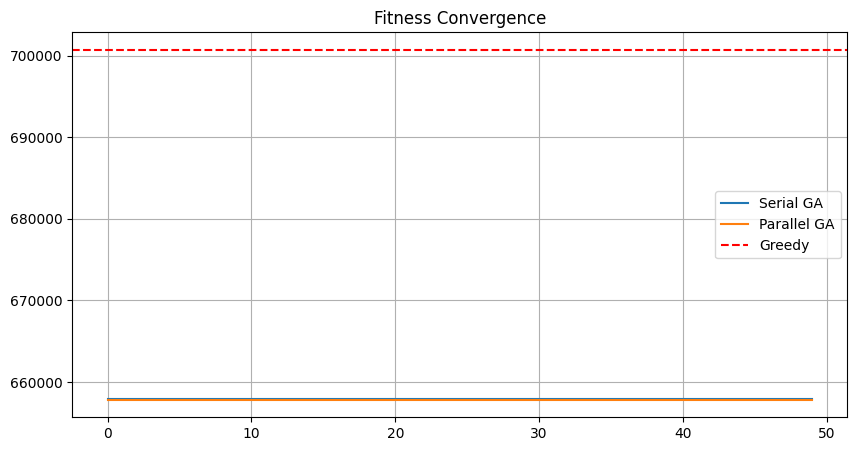

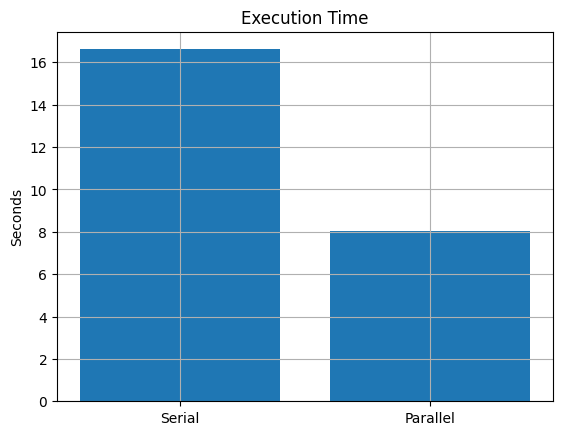

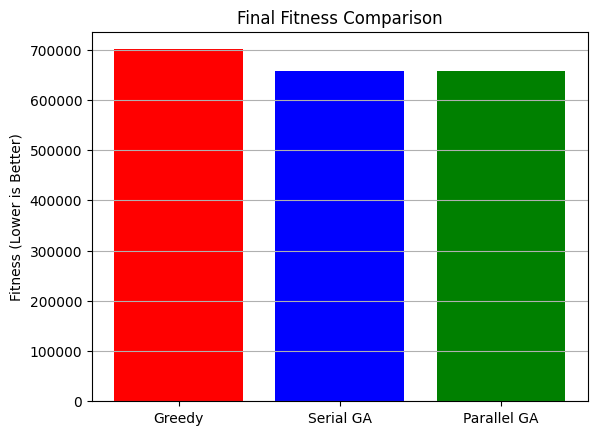

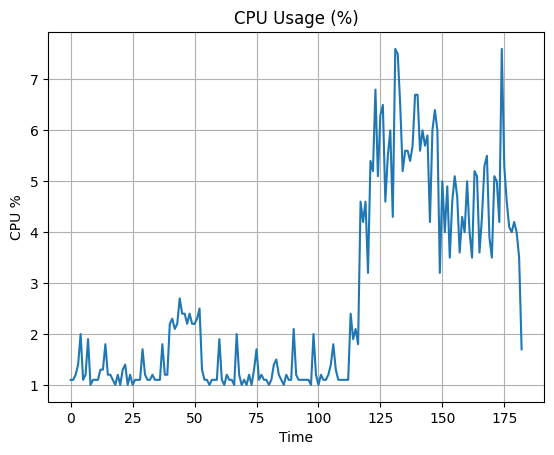

In [20]:

if __name__ == "__main__":
    data = load_energy_data("Smartgrid.csv")
    cost_matrix = create_cost_matrix(data)

    print("Running Greedy Baseline...")
    greedy_sol = initialize_population(data, 1)[0]
    greedy_fit = fitness(greedy_sol, data, cost_matrix)
    print(f"Greedy fitness: {greedy_fit:.2f}")

    start_monitoring()

    print("\nRunning Serial GA...")
    t0 = time.time()
    best_s, fit_s, hist_s = run_ga(data, pop_size=200, generations=50, parallel=False)
    t1 = time.time() - t0
    print(f"Serial GA fitness: {fit_s:.2f} in {t1:.2f}s")

    print("\nRunning Parallel GA...")
    t2 = time.time()
    best_p, fit_p, hist_p = run_ga(data, pop_size=200, generations=50, parallel=True)
    t3 = time.time() - t2
    print(f"Parallel GA fitness: {fit_p:.2f} in {t3:.2f}s")

    stop_monitoring()

    plot_results(greedy_fit, fit_s, fit_p, t1, t3, hist_s, hist_p)
